## Import Data and libraries

Import all librarys we need during the notebook

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.layers import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
import scipy
from keras.applications import MobileNetV2, VGG16, InceptionV3
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.utils import load_img, img_to_array
from keras.models import load_model
from keras.optimizers import Adam, SGD
import os

Check if tensorflow is using the GPU

In [2]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Load the data of the directory

In [6]:
data_dir = "./data/Train/"

Split the data in 2 dataset: 1 for train and another for validation.

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256,256),
  batch_size=32)

Found 4070 files belonging to 5 classes.
Using 3256 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(256,256),
  batch_size=32)

Found 4070 files belonging to 5 classes.
Using 814 files for validation.


In [9]:
class_names = train_ds.class_names
print(f'This is the list of the names of all classes {class_names}')

This is the list of the names of all classes ['Bathroom', 'Bedroom', 'House Map', 'Kitchen', 'Living Room']


#### Dataset exploration

Show a sample of the 9 first images with their own labels

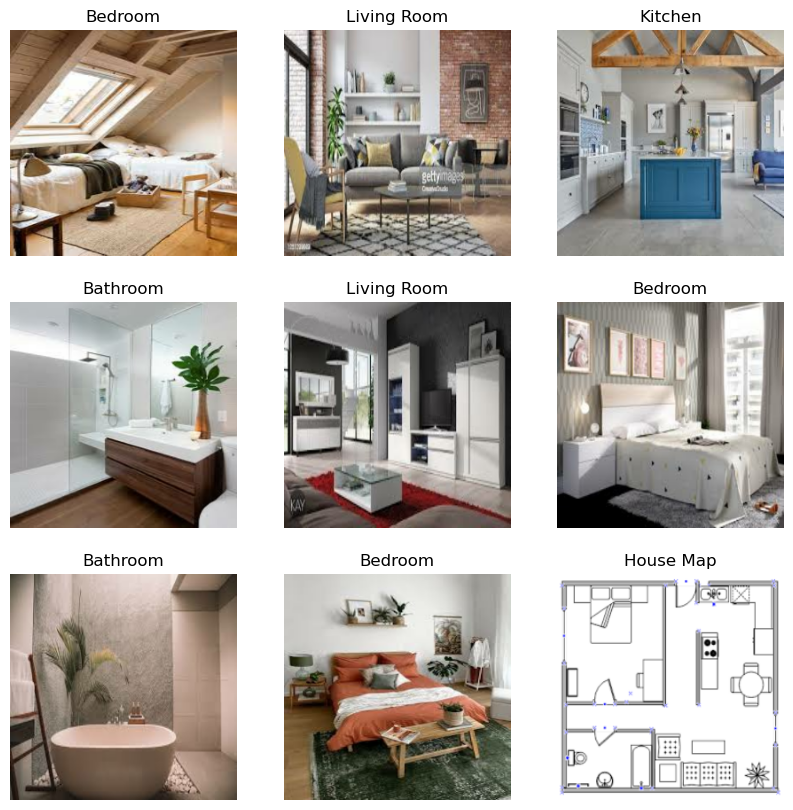

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

We see that the each batch have 32 images and each image have the dimensions of (256,256,3) where 3 mean the RGB of each pixel

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


Lets show how much images we have in the training for class

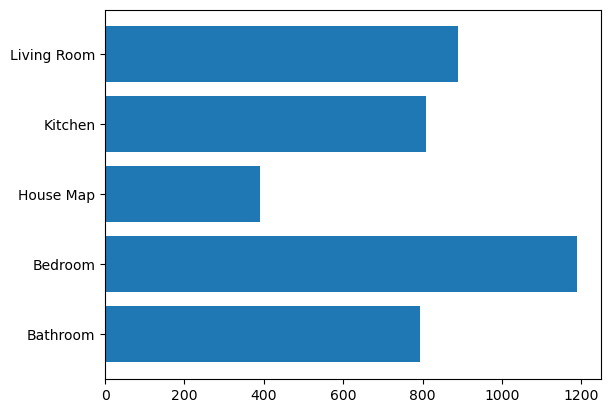

In [17]:
# Obtain a list of each folder of the directory
folders = os.listdir(data_dir)

# Arrays to store the folder names and number of files in each
folder_names = []
num_files = []

# Loop through the list and count the number of files in each folder
for item in folders:
    if os.path.isdir(os.path.join(data_dir, item)):
        # Get a list of all files in the folder
        files_in_folder = os.listdir(os.path.join(data_dir, item))
        # Count the number of files in the folder
        count = len([f for f in files_in_folder if os.path.isfile(os.path.join(data_dir, item, f))])
        # Add the folder name and number of files to the arrays
        folder_names.append(item)
        num_files.append(count)

# Create the horizontal bar chart
plt.barh(folder_names, num_files)

# Show the chart
plt.show()

# Preprocess data

Scale the image dividing it by 255

In [9]:
normalization_layer = Rescaling(1./255)

In [10]:
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
normalized_valid_ds = val_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
#Print the min and max to check if is right normalized [0,1] 
print(np.min(first_image),np.max(first_image))

0.011127547 1.0


# Train the models

## Model trained using convultional neural network

First we create a convultional neural network with all layers we find 

In [11]:
numberOfClass = len(class_names)
def def_conv_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32,(3,3),input_shape = input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Conv2D(32,(3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Conv2D(64,(3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(numberOfClass)) # output
    model.add(Activation("softmax"))
    return model

In [12]:
conv_model = def_conv_model(input_shape=(256,256,3))

In [13]:
conv_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 activation (Activation)     (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 125, 125, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                    

In [15]:
epochs=20
conv_hist = conv_model.fit(
  normalized_train_ds,
  validation_data= normalized_valid_ds,
  epochs=epochs
)

Epoch 1/20


c:\Users\danie\miniconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


102/102 [==============================] - 16s 88ms/step - loss: 1.8319 - accuracy: 0.2970 - val_loss: 1.3747 - val_accuracy: 0.3956
Epoch 2/20
102/102 [==============================] - 8s 80ms/step - loss: 1.2739 - accuracy: 0.4484 - val_loss: 1.1938 - val_accuracy: 0.4754
Epoch 3/20
102/102 [==============================] - 8s 81ms/step - loss: 1.0091 - accuracy: 0.5912 - val_loss: 1.1205 - val_accuracy: 0.5369
Epoch 4/20
102/102 [==============================] - 9s 81ms/step - loss: 0.7371 - accuracy: 0.7061 - val_loss: 1.2315 - val_accuracy: 0.5442
Epoch 5/20
102/102 [==============================] - 9s 82ms/step - loss: 0.4614 - accuracy: 0.8274 - val_loss: 1.2773 - val_accuracy: 0.5885
Epoch 6/20
102/102 [==============================] - 9s 82ms/step - loss: 0.2984 - accuracy: 0.9029 - val_loss: 1.4266 - val_accuracy: 0.5934
Epoch 7/20
102/102 [==============================] - 9s 81ms/step - loss: 0.1788 - accuracy: 0.9438 - val_loss: 1.5441 - val_accuracy: 0.5921
Epoch 8/2

In [28]:
def plot_history(history,epochs = 20):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

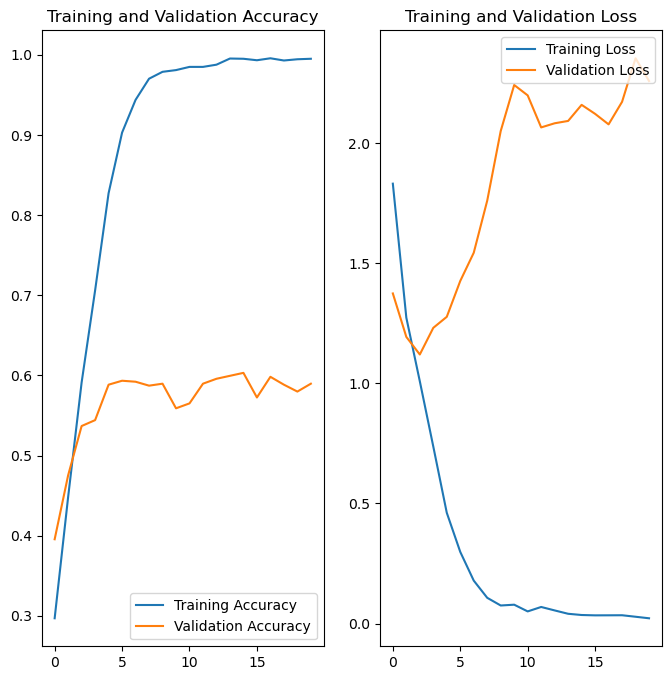

In [17]:
plot_history(conv_hist)

## Model with convolutional neural network using image data generator

In [10]:
width_shape = 224
height_shape = 224
num_classes = len(class_names)
epochs = 50
batch_size = 32 

We are going to apply the Image Data Generator keras function to modify the images of the training dataset applying some random zoom , some shear and a random horizontal flip because the photographs uploaded by the user will be usual people not professional photographer.
In the validation dataset we only rescale as we did before.

In [19]:

train_datagen = ImageDataGenerator( 
    rescale= 1./255,
    zoom_range=0.2,
    shear_range= 0.2,    
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split= 0.2)


valid_datagen = ImageDataGenerator(rescale= 1./255, validation_split= 0.2)

train_generator = train_datagen.flow_from_directory(data_dir,
    target_size=(width_shape, height_shape),
    color_mode="rgb",
    class_mode='categorical',
    subset= "training",
    batch_size= batch_size)

valid_generator = valid_datagen.flow_from_directory(data_dir,
    target_size=(width_shape, height_shape),
    color_mode="rgb",
    class_mode='categorical',
    subset= "validation",
    batch_size= batch_size)


Found 3258 images belonging to 5 classes.
Found 812 images belonging to 5 classes.


We print all classes and the first value to verify is correct

In [20]:

print(train_generator.class_indices)
print(train_generator.next()[0][1])

{'Bathroom': 0, 'Bedroom': 1, 'House Map': 2, 'Kitchen': 3, 'Living Room': 4}
[[[0.8562478  0.10067011 0.01790903]
  [0.8562478  0.10067011 0.01790903]
  [0.8562478  0.10067011 0.01790903]
  ...
  [0.7685117  0.7232675  0.6401534 ]
  [0.7685117  0.7232675  0.6401534 ]
  [0.7685117  0.7232675  0.6401534 ]]

 [[0.8635159  0.19861732 0.0631305 ]
  [0.8635159  0.19861732 0.0631305 ]
  [0.8635159  0.19861732 0.0631305 ]
  ...
  [0.7178285  0.6644907  0.5905702 ]
  [0.7178285  0.6644907  0.5905702 ]
  [0.7178285  0.6644907  0.5905702 ]]

 [[0.8235295  0.16862746 0.04313726]
  [0.8235295  0.16862746 0.04313726]
  [0.8235295  0.16862746 0.04313726]
  ...
  [0.6745098  0.60784316 0.5372549 ]
  [0.6745098  0.60784316 0.5372549 ]
  [0.6745098  0.60784316 0.5372549 ]]

 ...

 [[0.83921576 0.81568635 0.8235295 ]
  [0.83921576 0.81568635 0.8235295 ]
  [0.83921576 0.81568635 0.8235295 ]
  ...
  [0.8470589  0.8470589  0.8470589 ]
  [0.8470589  0.8470589  0.8470589 ]
  [0.8470589  0.8470589  0.8470589 

Plot examples of the images with data image generator

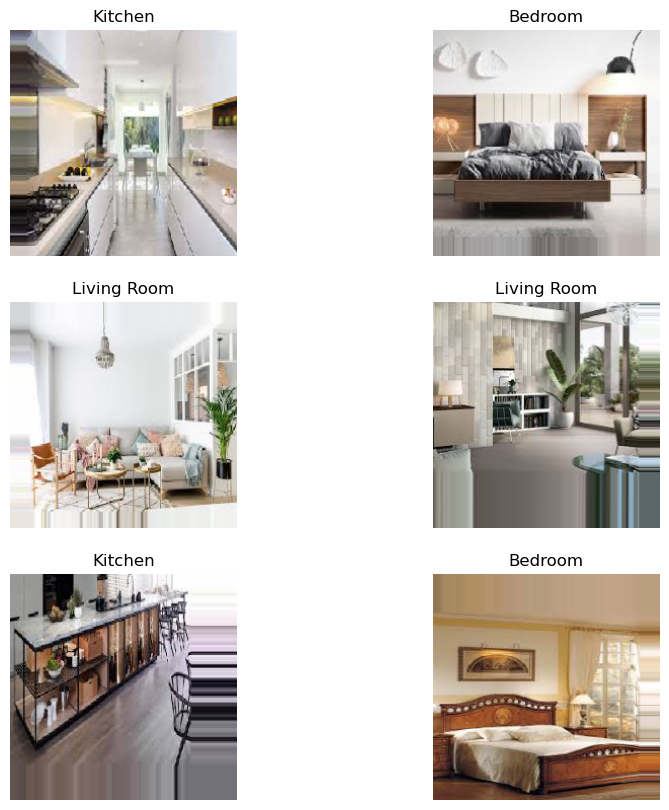

In [21]:
batch =  train_generator.next()
  
plt.figure(figsize=(10, 10))

for i in range(6):
  ax = plt.subplot(3, 2, i + 1)
  plt.imshow(batch[0][i])
  plt.title(class_names[np.argmax(batch[1][i])])
  plt.axis("off")

In [22]:
model_conv_with_data_gen = def_conv_model(input_shape=(224,224,3))

In [23]:
model_conv_with_data_gen.compile(optimizer = 'adam', loss = categorical_crossentropy, metrics = ['accuracy'] )

conv_hist_with_data_generator = model_conv_with_data_gen.fit(train_generator,
                           epochs = epochs,
                           validation_data= valid_generator
                           )

Epoch 1/50
 47/102 [============>.................] - ETA: 18s - loss: 1.8225 - accuracy: 0.2766

c:\Users\danie\miniconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


102/102 [==============================] - 39s 374ms/step - loss: 1.6277 - accuracy: 0.3036 - val_loss: 1.3508 - val_accuracy: 0.3793
Epoch 2/50
102/102 [==============================] - 38s 372ms/step - loss: 1.3359 - accuracy: 0.3969 - val_loss: 1.2918 - val_accuracy: 0.4483
Epoch 3/50
102/102 [==============================] - 38s 372ms/step - loss: 1.2722 - accuracy: 0.4233 - val_loss: 1.2605 - val_accuracy: 0.4569
Epoch 4/50
102/102 [==============================] - 38s 372ms/step - loss: 1.2077 - accuracy: 0.4583 - val_loss: 1.3778 - val_accuracy: 0.4754
Epoch 5/50
102/102 [==============================] - 38s 371ms/step - loss: 1.2021 - accuracy: 0.4684 - val_loss: 1.1481 - val_accuracy: 0.5086
Epoch 6/50
102/102 [==============================] - 39s 378ms/step - loss: 1.1795 - accuracy: 0.4828 - val_loss: 1.3161 - val_accuracy: 0.4741
Epoch 7/50
102/102 [==============================] - 38s 371ms/step - loss: 1.1566 - accuracy: 0.4939 - val_loss: 1.3502 - val_accuracy: 0.4

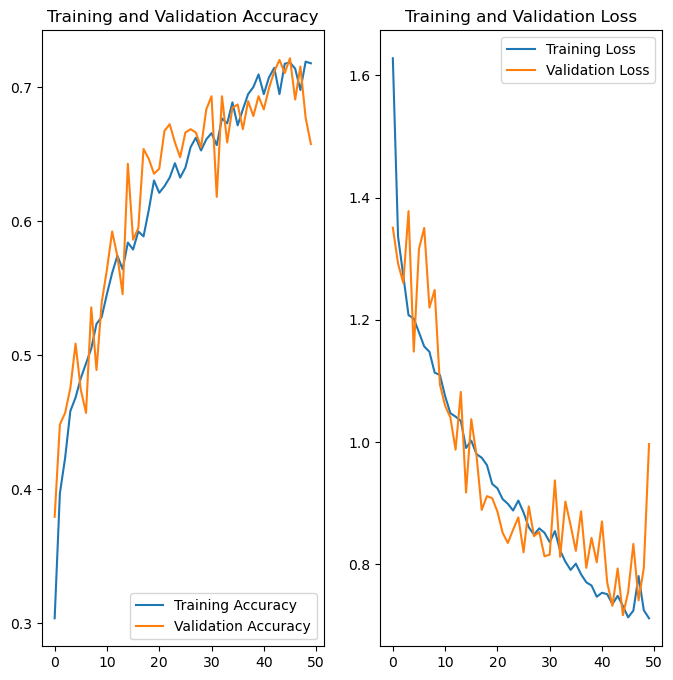

In [24]:
plot_history(conv_hist_with_data_generator)

### Defining a function to train a model using a pretrained model with a transfer learning technique

In [41]:
def train_transfer_learning_model(base_model):
  #Define the variables
  epochs = 15
  # Freeze base model layers
  for layer in base_model.layers:
    layer.trainable = False

  # Add new layers connected to the base model
  x=base_model.output
  x=GlobalAveragePooling2D()(x)
  x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
  x=Dense(1024,activation='relu')(x) #dense layer 2
  x=Dense(512,activation='relu')(x) #dense layer 3
  x = Dropout(0.5)(x)
  predictions=Dense(num_classes,activation='softmax')(x) #final layer with softmax activation

  # Create a model using the pretrained model
  transfer_learning_model = Model(inputs=base_model.input, outputs=predictions)

  # Compile the model using SGD
  transfer_learning_model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

  # Train the model
  transfer_learning_hist = transfer_learning_model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples/train_generator.batch_size ,
        epochs= epochs,
        validation_data=valid_generator,
        validation_steps=valid_generator.samples/valid_generator.batch_size,
        verbose=1)

  # Unfreeze all the layers of the model
  for layer in base_model.layers:
    layer.trainable = True

  # Compile the model but using a low learning rate
  transfer_learning_model.compile(optimizer=SGD(lr=0.0001, momentum= 0.9), loss='categorical_crossentropy', metrics=['accuracy'])

  # Train the model again
  fine_tuning_hist = transfer_learning_model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples/train_generator.batch_size ,
        epochs= epochs,
        validation_data=valid_generator,
        validation_steps=valid_generator.samples/valid_generator.batch_size,
        verbose=1)
  
  print("This is the historical of the transfer learning")
  plot_history(transfer_learning_hist,epochs)

  print("This is the historical of the fine tuning")
  plot_history(fine_tuning_hist,epochs)  

  return transfer_learning_model


### Transfer learning using MobileNetV2 model

c:\Users\danie\miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/15
 74/101 [====================>.........] - ETA: 10s - loss: 1.1908 - accuracy: 0.5215

c:\Users\danie\miniconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


101/101 [==============================] - 43s 400ms/step - loss: 1.0719 - accuracy: 0.5761 - val_loss: 0.5754 - val_accuracy: 0.8017
Epoch 2/15
101/101 [==============================] - 41s 393ms/step - loss: 0.6026 - accuracy: 0.7772 - val_loss: 0.3986 - val_accuracy: 0.8473
Epoch 3/15
101/101 [==============================] - 40s 397ms/step - loss: 0.4987 - accuracy: 0.8161 - val_loss: 0.3593 - val_accuracy: 0.8633
Epoch 4/15
101/101 [==============================] - 40s 389ms/step - loss: 0.4519 - accuracy: 0.8379 - val_loss: 0.3391 - val_accuracy: 0.8756
Epoch 5/15
101/101 [==============================] - 40s 388ms/step - loss: 0.4196 - accuracy: 0.8502 - val_loss: 0.3322 - val_accuracy: 0.8768
Epoch 6/15
101/101 [==============================] - 40s 386ms/step - loss: 0.4062 - accuracy: 0.8527 - val_loss: 0.3195 - val_accuracy: 0.8744
Epoch 7/15
101/101 [==============================] - 40s 392ms/step - loss: 0.3925 - accuracy: 0.8653 - val_loss: 0.3432 - val_accuracy: 0.8

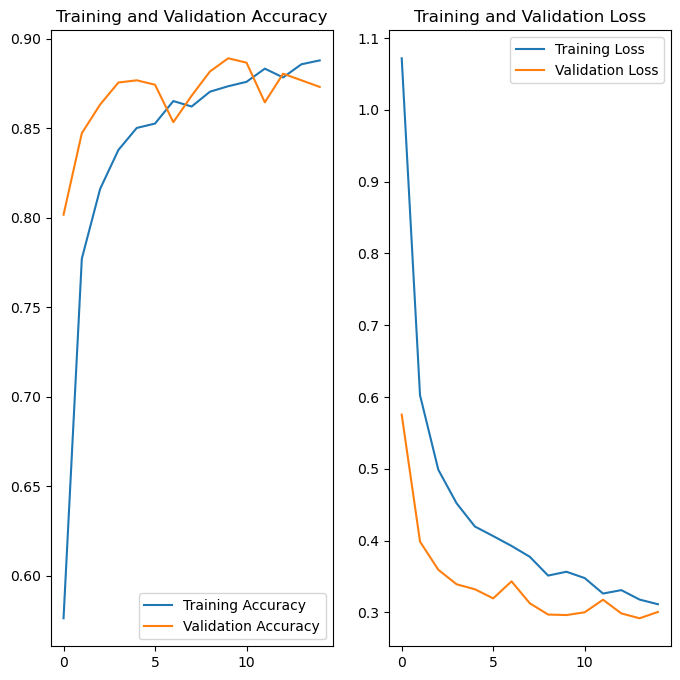

This is the historical of the fine tuning


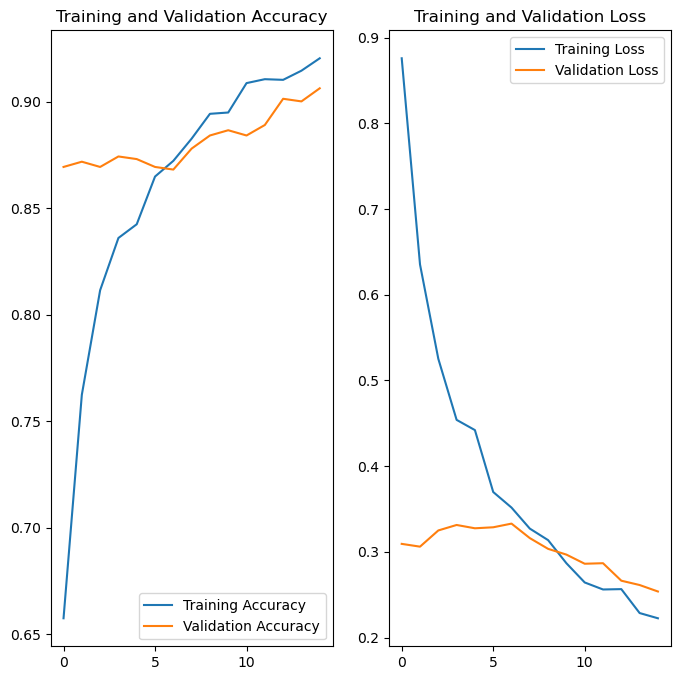

In [42]:
mobile_base=MobileNetV2(weights='imagenet',include_top=False) #imports the mobilenet model without the input layer

mobilenet_model = train_transfer_learning_model(mobile_base)

In [43]:
mobilnet_results = mobilenet_model.evaluate_generator(valid_generator)
print("Loss: ",mobilnet_results[0])
print("Accuracy: ", mobilnet_results[1])

C:\Users\danie\AppData\Local\Temp\ipykernel_16284\270682978.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  mobilnet_results = mobilenet_model.evaluate_generator(valid_generator)


Loss:  0.2536853551864624
Accuracy:  0.9064039587974548


### Transfer learning using VGG16 model

Epoch 1/15
101/101 [==============================] - 48s 424ms/step - loss: 1.4978 - accuracy: 0.3085 - val_loss: 1.3658 - val_accuracy: 0.3867
Epoch 2/15
101/101 [==============================] - 38s 372ms/step - loss: 1.3525 - accuracy: 0.4196 - val_loss: 1.2089 - val_accuracy: 0.5320
Epoch 3/15
101/101 [==============================] - 38s 373ms/step - loss: 1.2433 - accuracy: 0.4736 - val_loss: 1.0909 - val_accuracy: 0.5493
Epoch 4/15
101/101 [==============================] - 38s 372ms/step - loss: 1.1516 - accuracy: 0.5273 - val_loss: 1.0034 - val_accuracy: 0.5985
Epoch 5/15
101/101 [==============================] - 38s 376ms/step - loss: 1.0893 - accuracy: 0.5531 - val_loss: 0.9428 - val_accuracy: 0.6355
Epoch 6/15
101/101 [==============================] - 38s 375ms/step - loss: 1.0355 - accuracy: 0.5749 - val_loss: 0.9109 - val_accuracy: 0.6367
Epoch 7/15
101/101 [==============================] - 38s 374ms/step - loss: 0.9937 - accuracy: 0.5899 - val_loss: 0.8459 - val_ac

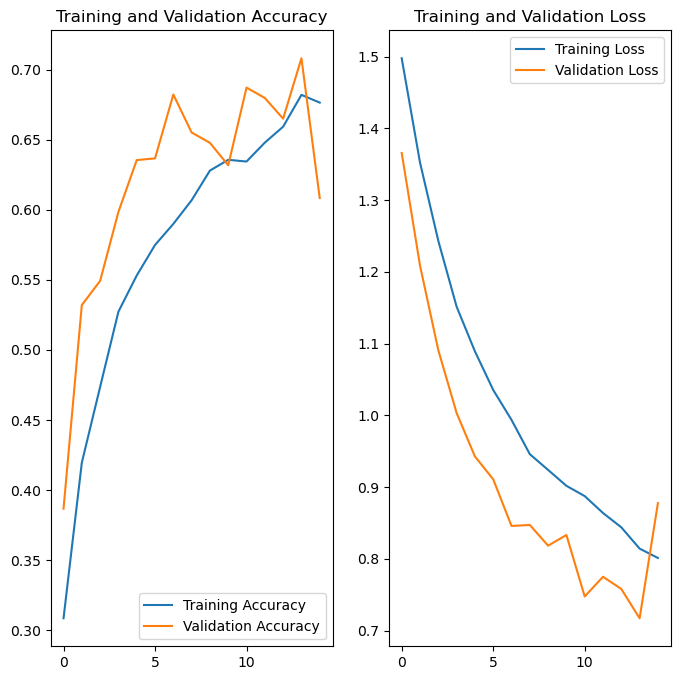

This is the historical of the fine tuning


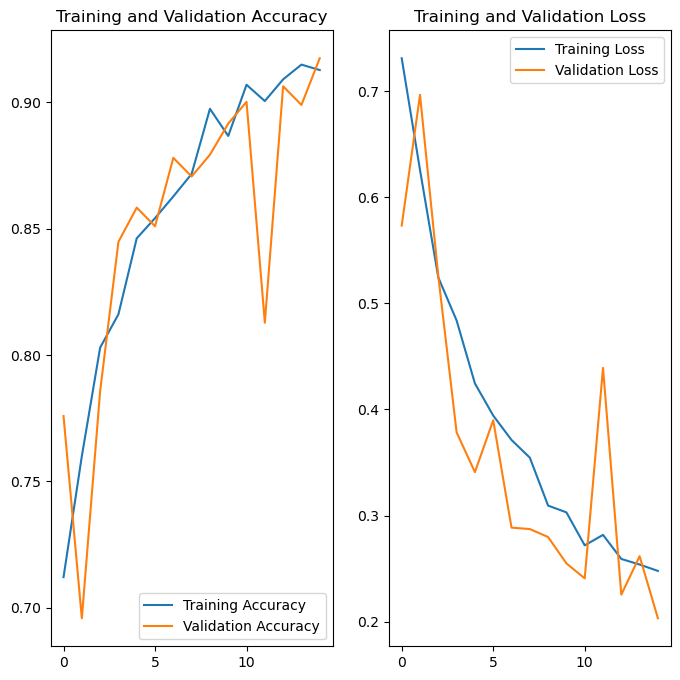

In [45]:
vgg_base=VGG16(weights='imagenet',include_top=False) #imports the VGG model without the input layer

vgg_model = train_transfer_learning_model(vgg_base)

In [46]:
vgg_results = vgg_model.evaluate_generator(valid_generator)
print("Loss: ",vgg_results[0])
print("Accuracy: ", vgg_results[1])

C:\Users\danie\AppData\Local\Temp\ipykernel_16284\2504925563.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  vgg_results = vgg_model.evaluate_generator(valid_generator)


Loss:  0.20335187017917633
Accuracy:  0.9174876809120178


### Transfer learning using InceptionV3 model

Epoch 1/15
101/101 [==============================] - 45s 403ms/step - loss: 1.0177 - accuracy: 0.5945 - val_loss: 0.5413 - val_accuracy: 0.8005
Epoch 2/15
101/101 [==============================] - 38s 376ms/step - loss: 0.6631 - accuracy: 0.7526 - val_loss: 0.4882 - val_accuracy: 0.7993
Epoch 3/15
101/101 [==============================] - 38s 374ms/step - loss: 0.5873 - accuracy: 0.7796 - val_loss: 0.3947 - val_accuracy: 0.8473
Epoch 4/15
101/101 [==============================] - 38s 376ms/step - loss: 0.5669 - accuracy: 0.7876 - val_loss: 0.3803 - val_accuracy: 0.8461
Epoch 5/15
101/101 [==============================] - 38s 375ms/step - loss: 0.5157 - accuracy: 0.8158 - val_loss: 0.3865 - val_accuracy: 0.8485
Epoch 6/15
101/101 [==============================] - 39s 379ms/step - loss: 0.4899 - accuracy: 0.8125 - val_loss: 0.3780 - val_accuracy: 0.8473
Epoch 7/15
101/101 [==============================] - 38s 378ms/step - loss: 0.4838 - accuracy: 0.8195 - val_loss: 0.3370 - val_ac

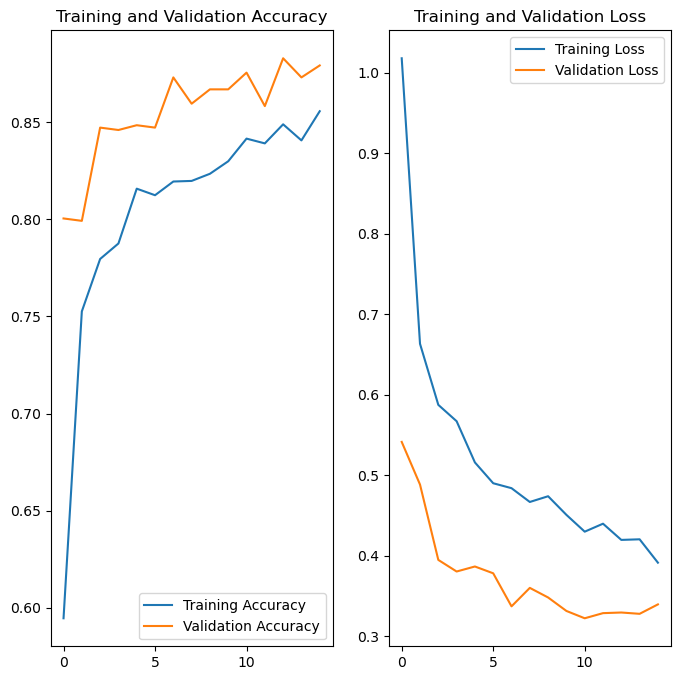

This is the historical of the fine tuning


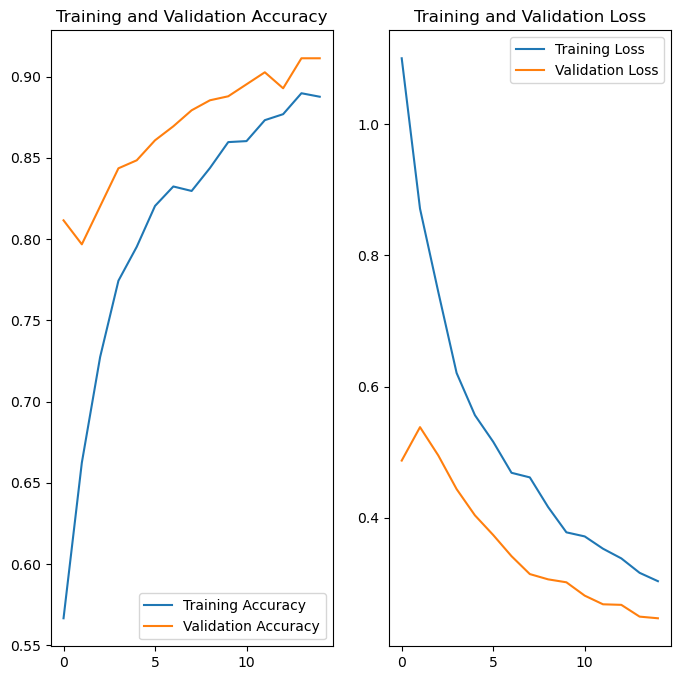

In [47]:
inception_base=InceptionV3(weights='imagenet',include_top=False) #imports the Inception model without the input layer

inception_model = train_transfer_learning_model(inception_base)

In [48]:
inception_results = inception_model.evaluate_generator(valid_generator)
print("Loss: ",inception_results[0])
print("Accuracy: ", inception_results[1])

C:\Users\danie\AppData\Local\Temp\ipykernel_16284\2662452695.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  inception_results = inception_model.evaluate_generator(valid_generator)


Loss:  0.24665914475917816
Accuracy:  0.9113300442695618


#### Save the VGG model the one that have the best accuracy 

In [49]:
vgg_model.save(filepath="Models\model_transfer_learning\model_transfer_learning.h5", overwrite= True) #Save best transfer model learning VGG

In [3]:
vgg_model = load_model("Models\model_transfer_learning\model_transfer_learning.h5")

#### Load images and test if the prediction of the model is correct

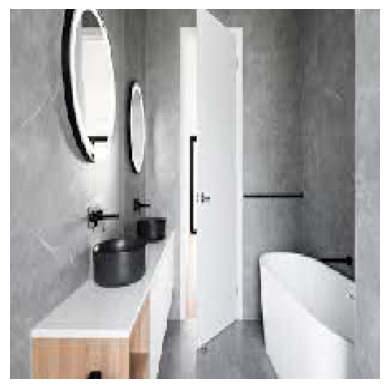

1/1 [==============================] - 7s 7s/step
The prediction is Bathroom


In [13]:
def load_image(img_path, show=False):


    img = load_img(img_path, target_size=(width_shape, height_shape))
    img_tensor =    img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.  
    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor
  
#img_path = 'C:/Users/Ferhat/Python Code/Workshop/Tensoorflow transfer learning/blue_tit.jpg'
img_path = r'C:\Users\danie\OneDrive\Documentos\GitHub\RoomsClassifier\data\Test\Bathroom\0.jpg'
new_image = load_image(img_path,show=True)

pred = vgg_model.predict(new_image)

print(f'The prediction is {class_names[np.argmax(pred)]}')


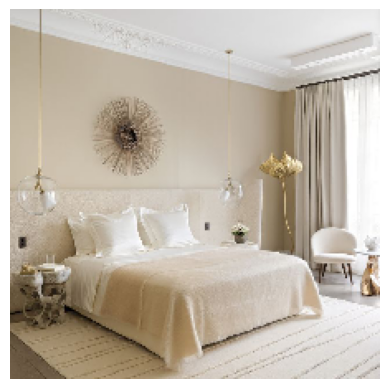

1/1 [==============================] - 0s 22ms/step
The prediction is Bedroom


In [14]:
#img_path = 'C:/Users/Ferhat/Python Code/Workshop/Tensoorflow transfer learning/blue_tit.jpg'
img_path = r'C:\Users\danie\OneDrive\Documentos\GitHub\RoomsClassifier\data\Test\Bedroom\dormitorio_paris.jpg'
new_image = load_image(img_path,show=True)

pred = vgg_model.predict(new_image)

print(f'The prediction is {class_names[np.argmax(pred)]}')


## Load test data

In [15]:
test_dir = "data\Test"

In [16]:
test_datagen = ImageDataGenerator(rescale= 1./255)


test_generator = test_datagen.flow_from_directory(test_dir,
    target_size=(width_shape, height_shape),
    color_mode="rgb",
    class_mode='categorical',
    batch_size= batch_size)


Found 720 images belonging to 5 classes.


In [17]:
best_model_results = vgg_model.evaluate_generator(test_generator)
print("Loss: ",best_model_results[0])
print("Accuracy: ", best_model_results[1])

C:\Users\danie\AppData\Local\Temp\ipykernel_16208\4099665524.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  best_model_results = vgg_model.evaluate_generator(test_generator)


Loss:  0.37056243419647217
Accuracy:  0.8680555820465088
